# Monitoring script

This is work in progress. This is meant to end up as a python script (not a notebook) which is run after every slurm job. It should produce a set of images and a markdown file.

Todo:
- [ ] AKN says no histograms or only for the last time step
- [ ] DOM02 should be checked!
- [ ] time series should be done incremental. maybe averaging each file and creating a new file that then sits there. checking if a file already exists is much easier than checking if a timespan already exists.

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import postprocessing as pp
import calculations as cc
import importlib; importlib.reload(pp)
import importlib; importlib.reload(cc)
import xarray as xr
import numpy as np
import file_handling as fh
import pandas as pd

import matplotlib.pyplot as plt
import plot_utils as pu

def postprocess(data):
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = pp.subsample_dataset(data)
    data = pp.replace_height_indices_with_values(data)
    data = data.mean(dim=['cell'], keep_attrs=True)
    data = pp.convert_units('hPa', data, 'pres')
    return data

def plot_vertical_profile(ax, data, **kwargs):
    x = data
    y = data[data.dims[0]] / 1000
    y.attrs = {'long_name':'heigth', 'units':'km'}
    ax.plot(x,y, **kwargs)
    ax.set_xlabel(f"{x.attrs['long_name']} / {x.attrs['units']}")
    ax.set_ylabel(f"{y.attrs['long_name']} / {y.attrs['units']}")
    ax.set_ylim(0, max(y))
    return ax

def fig_vertical_profile_diff_to_control(path, domain, integration_time, var_list):
    data = fh.disk_data_from_keywords(path, [f'{domain}_3D'])
    data = pp.clean_volume_data(data)
    data = postprocess(data)
    start_interval = pp.get_interval(data.time.values[ 0],     integration_time)
    end_interval   = pp.get_interval(data.time.values[-1], '-'+integration_time)

    refd = fh.eureca_data_from_keywords([domain, '3D'])
    refd = postprocess(refd)

    fig, axs = plt.subplots(1,4, figsize=(15,5))

    for ax, var in zip(axs, var_list):

        for interval, label in zip([start_interval, end_interval], [f'first {integration_time} mean', f'last {integration_time} mean']):
            d = pp.cut_time_interval(data, interval)
            r = pp.cut_time_interval(refd, interval)
            if var == 'RH': 
                d = cc.add_relative_humidity(d)
                r = cc.add_relative_humidity(r)
            d = d[var].mean(dim='time', keep_attrs=True)
            r = r[var].mean(dim='time', keep_attrs=True)
            d.values -= r.values
            ax = plot_vertical_profile(ax, d, label=label)

        ax = pu.remove_spines(ax, ['top','right'])
        ax.grid(axis='y')

    ax.legend()
    for ax in axs[1::]:
        ax = pu.remove_ticks(ax, ['left','right'])
        ax.set_ylabel(None)

    fig.suptitle(f'diff to control')
    return fig, axs

def fig_vertical_profiles_compare2control(path, domain, integration_time, var_list):
    data = fh.disk_data_from_keywords(path, [f'{domain}_3D'])
    data = pp.clean_volume_data(data)
    data = postprocess(data)
    start_interval = pp.get_interval(data.time.values[ 0],     integration_time)
    end_interval   = pp.get_interval(data.time.values[-1], '-'+integration_time)

    refd = fh.eureca_data_from_keywords([domain, '3D'])
    refd = postprocess(refd)

    fig, axs = plt.subplots(1,4, figsize=(15,5))

    for ax, var in zip(axs, var_list):
        interval = end_interval
        label = f'last {integration_time} mean'
        d = pp.cut_time_interval(data, interval)
        r = pp.cut_time_interval(refd, interval)
        if var == 'RH': 
            d = cc.add_relative_humidity(d)
            r = cc.add_relative_humidity(r)
        d = d[var].mean(dim='time', keep_attrs=True)
        r = r[var].mean(dim='time', keep_attrs=True)
        ax = plot_vertical_profile(ax, r, label='control', ls=':')
        ax = plot_vertical_profile(ax, d, label=label)
        ax = pu.remove_spines(ax, ['top','right'])
        ax.grid(axis='y')

    ax.legend()
    for ax in axs[1::]:
        ax = pu.remove_ticks(ax, ['left','right'])
        ax.set_ylabel(None)

    fig.suptitle(f'vertical profiles, compared to control run, last {integration_time}')
    return fig, axs

def fig_some_vertical_profiles_compare2control(path, domain):
    integration_time = '3.5h'
    var_list = ['temp', 'qv', 'pres', 'RH']
    return  fig_vertical_profiles_compare2control(path, domain, integration_time, var_list)

def fig_some_vertical_profiles_rhofix_diff2ctrl(path, domain):
    integration_time = '3.5h'
    var_list = ['temp', 'qv', 'pres', 'RH']
    return  fig_vertical_profile_diff_to_control(path, domain, integration_time, var_list)

def print_last_timesteps(path, domain):
    def print_last_timestep(data):
        data = pp.replace_icon2datetime(data)
        last_timestep = data.time.values[-1]
        return pd.to_datetime(last_timestep)
    data = fh.disk_data_from_keywords(path, [domain, 'surface'], supress_warning=True)
    print('Last 2D output at:', print_last_timestep(data))
    data = fh.disk_data_from_keywords(path, [f'{domain}_3D'], supress_warning=True)
    print('Last 3D output at:', print_last_timestep(data))

def fig_histogram_variable_2ddata(path, domain, variable):
    
    def load_disk_data(path, domain='DOM01'):
        data = fh.disk_data_from_keywords(path, [domain,'surface'])
        data = pp.clean_surface_data(data)
        return data

    def load_eurec4a_data(domain='DOM01'):
        data = fh.eureca_data_from_keywords([f'surface_{domain}'])
        return data

    def postprocess(data):
        data = pp.add_grid(data)
        data = pp.subsample_dataset(data, {'cell':4**4})
        data = pp.cut_borders(data)
        return data
    
    fig, ax = plt.subplots()
    kwargs_general = dict(histtype='stepfilled', density=True, bins=40, fill=None)
    kwargs = [{'label':'control',     'ec' : 'black', }, 
              {'label':'warm, rho-fixed', 'ec' : 'red'}]
    
    datasets = [postprocess(load_disk_data(path, domain))]
    timespan = datasets[0].time.values[0], datasets[0].time.values[-1]
    data = load_eurec4a_data()
    data = postprocess(data)
    data = data.sel(time=(data.time.values > np.datetime64(timespan[0])))
    data = data.sel(time=(data.time.values < np.datetime64(timespan[1])))
    datasets.insert(0, data)
    
    for data, kwargs_specific in zip(datasets, kwargs):
        kwargs = {**kwargs_specific, **kwargs_general}
        reduced_data = np.ravel(data[variable].values)
        ax.axvline(np.mean(reduced_data), color=kwargs['ec'], ls=':')
        # print(kwargs['label'], np.nanmean(reduced_data))
        kwargs['label'] += f', {np.nanmean(reduced_data):.2f}'
        ax.hist(reduced_data, **kwargs)
        ax.set_xlabel(f'{data[variable].long_name} / {data[variable].units}')
    ax.legend(loc='upper left')
    ax.set_title(f'Histogram of {data[variable].long_name} in EUREC4A simulations')
    fig.tight_layout()
    return fig, ax

domain = 'DOM01'
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'

In [2]:
# # fig, ax = fig_histogram_variable_2ddata(path, domain, 'u_10m')
# fig, ax = fig_histogram_variable_2ddata(path, domain, 'lhfl_s')
# fig.show()

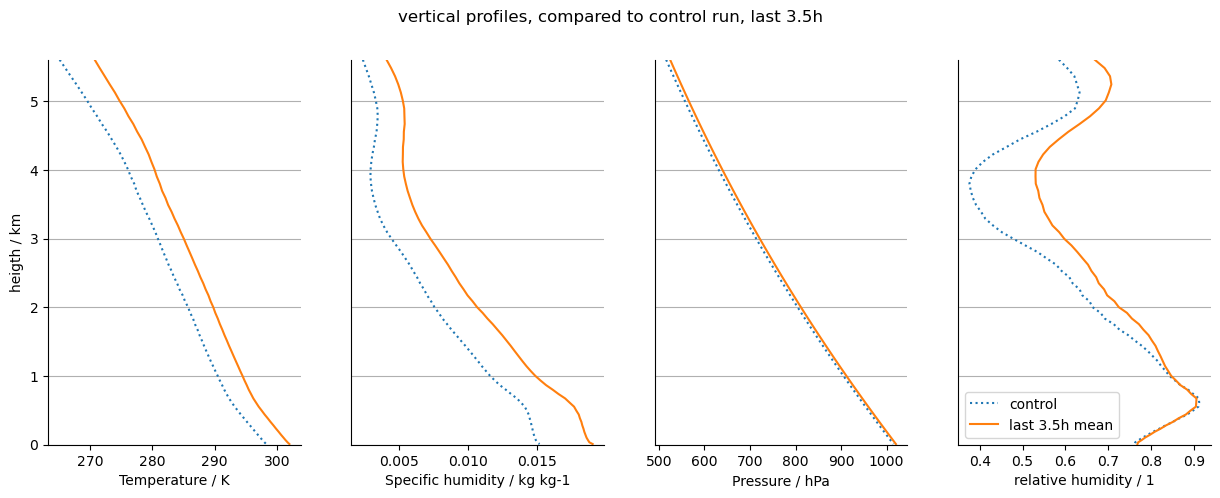

In [3]:
domain = 'DOM01'
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    
fig, axs = fig_some_vertical_profiles_compare2control(path, domain)
fig.show()

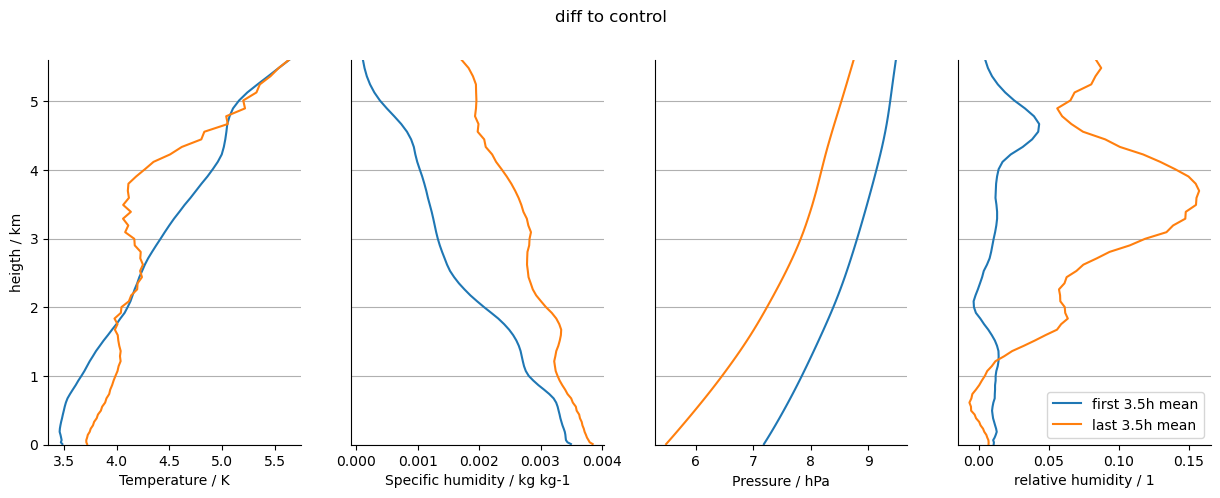

In [4]:
fig, axs = fig_some_vertical_profiles_rhofix_diff2ctrl(path, domain)
fig.show()

In [5]:
print_last_timesteps(path, domain)

Last 2D output at: 2020-01-14 05:30:00
Last 3D output at: 2020-01-14 05:00:00


In [6]:
f'{cc.get_z_half()[-1]:.1f}'

'21000.0'

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:949: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn("There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!")
/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


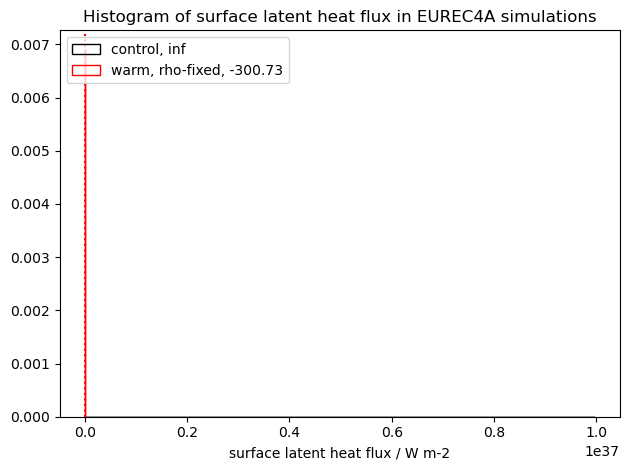

In [7]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import postprocessing as pp
import calculations as cc
import importlib; importlib.reload(pp)
import importlib; importlib.reload(cc)
import xarray as xr
import numpy as np
import file_handling as fh
import pandas as pd

import matplotlib.pyplot as plt
import plot_utils as pu

def fig_histogram_variable_2ddata(path, domain, variable):
    
    def load_disk_data(path, domain='DOM01'):
        data = fh.disk_data_from_keywords(path, [domain,'surface'])
        data = pp.clean_surface_data(data)
        return data

    def load_eurec4a_data(domain='DOM01'):
        data = fh.eureca_data_from_keywords([f'surface_{domain}'])
        return data

    def postprocess(data):
        data = pp.add_grid(data)
        # data = pp.subsample_dataset(data)
        data = pp.cut_borders(data)
        return data
    
    fig, ax = plt.subplots()
    kwargs_general = dict(histtype='stepfilled', density=True, bins=40, fill=None)
    kwargs = [{'label':'control',     'ec' : 'black', }, 
              {'label':'warm, rho-fixed', 'ec' : 'red'}]
    
    datasets = [postprocess(load_disk_data(path, domain))]
    timespan = datasets[0].time.values[0], datasets[0].time.values[-1]
    data = load_eurec4a_data()
    data = postprocess(data)
    data = data.sel(time=(data.time.values > np.datetime64(timespan[0])))
    data = data.sel(time=(data.time.values < np.datetime64(timespan[1])))
    datasets.insert(0, data)
    
    for data, kwargs_specific in zip(datasets, kwargs):
        kwargs = {**kwargs_specific, **kwargs_general}
        reduced_data = np.ravel(data[variable].values)
        ax.axvline(np.mean(reduced_data), color=kwargs['ec'], ls=':')
        # print(kwargs['label'], np.nanmean(reduced_data))
        kwargs['label'] += f', {np.nanmean(reduced_data):.2f}'
        ax.hist(reduced_data, **kwargs)
        ax.set_xlabel(f'{data[variable].long_name} / {data[variable].units}')
    ax.legend(loc='upper left')
    ax.set_title(f'Histogram of {data[variable].long_name} in EUREC4A simulations')
    fig.tight_layout()
    return fig, ax

# domain = 'DOM01'
# path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'

# # fig, ax = fig_histogram_variable_2ddata(path, domain, 'u_10m')
# fig, ax = fig_histogram_variable_2ddata(path, domain, 'lhfl_s')
# fig.show()

print('no histograms, or histograms for only last timestep')

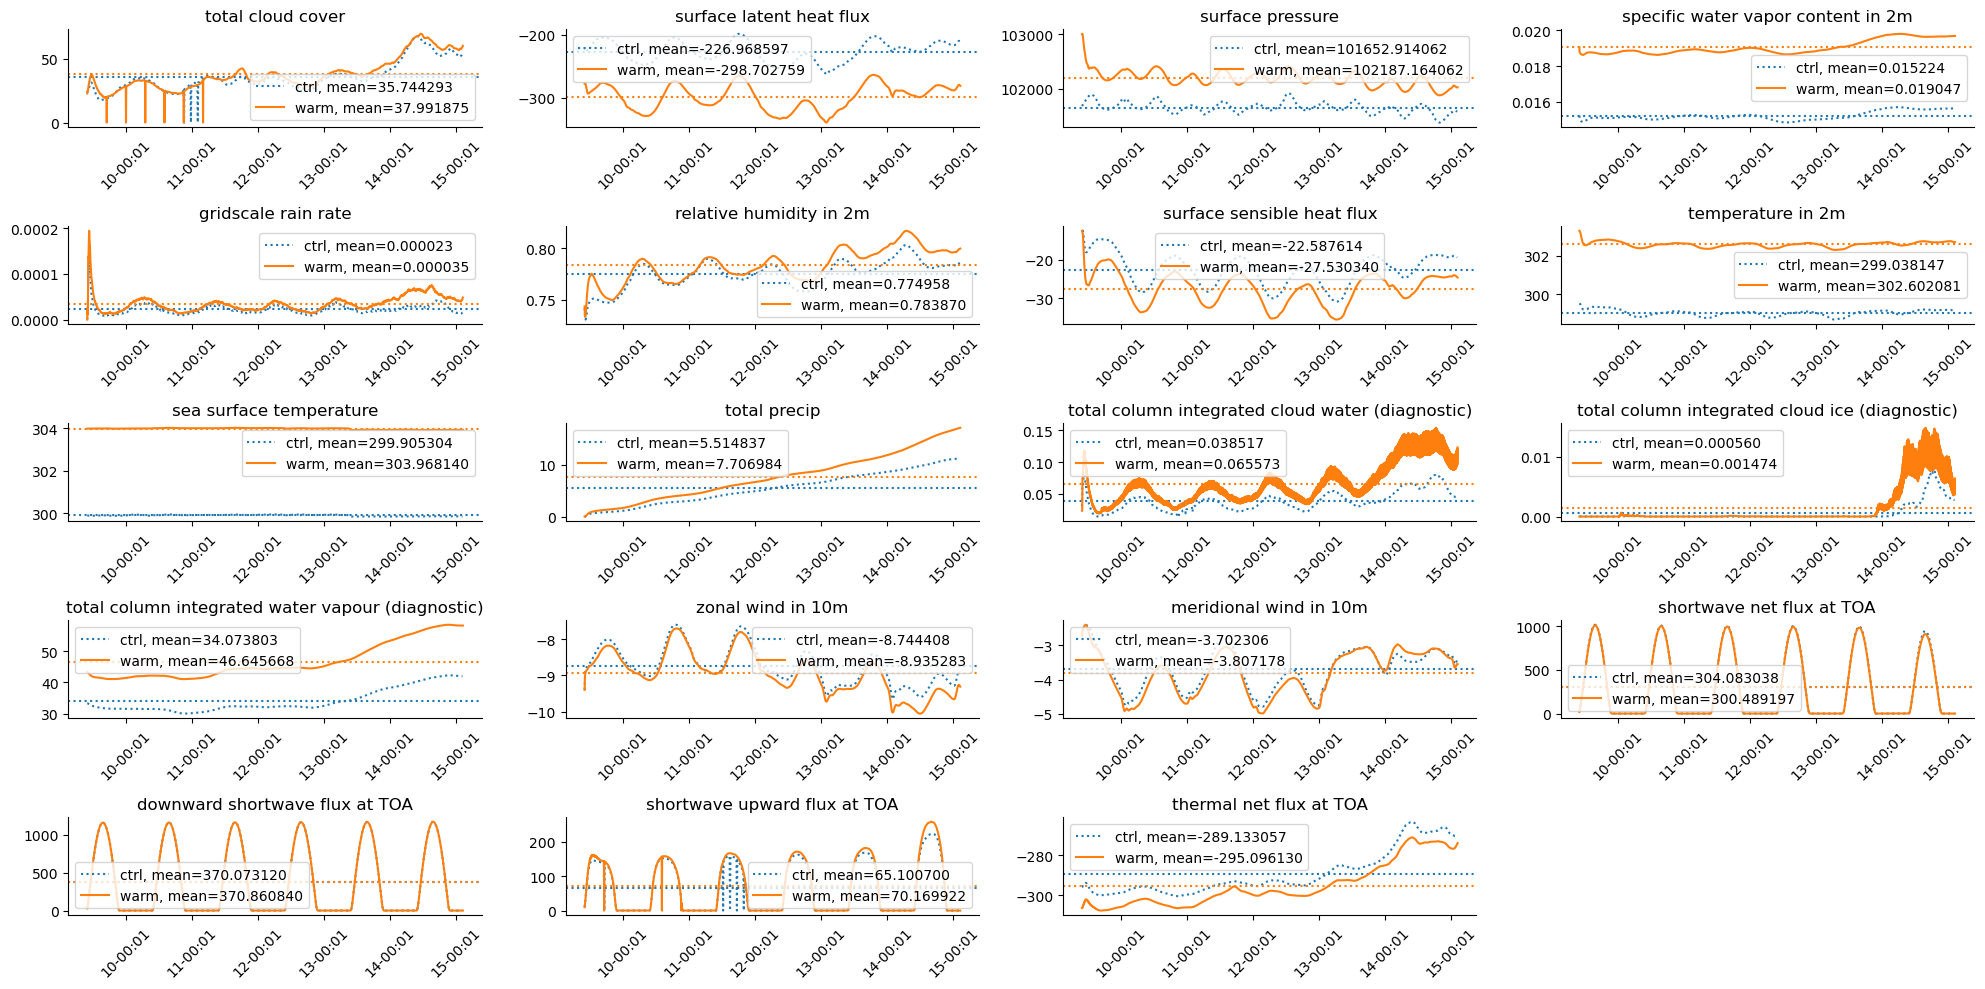

In [34]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import pandas as pd
import eurec4a
import xarray as xr    
import numpy as np
import postprocessing as pp
import file_handling as fh
import calculations as cc

import matplotlib.pyplot as plt
import matplotlib.dates
import plot_utils as pu

def save_composit_timeseries(path, savename, cut_borders=True):
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell').drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)
            
                
def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False, figsize=(20,10)):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=figsize)

    for i,var in enumerate(list(data[0])):
        ax = np.ravel(axs)[i]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, ls=':', color=kwargs[j]['color'])
            x = d[var].time
            y = d[var]
            ax.plot(x, y, label=f'{labels[j]}, mean={integral:3f}', **kwargs[j])
        ax.set_title(y.attrs['long_name'])
        ax.legend()
        ax = pu.remove_spines(ax, ['top', 'right'])
        
        def format_dates_on_axis(ax, format_string='%d-%H:%m', rotation=45):
            ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(format_string))
            if not rotation == None: ax.tick_params(axis='x', rotation=rotation)
            return ax
        
        ax = format_dates_on_axis(ax)

    for i in range(m*n - len(list(data[0]))): # remove empty plots
        pu.remove_spines(np.ravel(axs)[-(1+i)], ['left','right','top','bottom'])
        pu.remove_ticks(np.ravel(axs)[-(1+i)], ['left','right','top','bottom'])

    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warmingrun(verbose=False, time=None, mean=False):
    warming_timeseries = f'data/moistadabatic_{fh.timestamp(time)}.nc'
    control_timeseries = f'data/eurecasurface_{fh.timestamp(time)}.nc'
    if not os.path.exists(warming_timeseries):
        print(f'creating time series data: {warming_timeseries}')
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', warming_timeseries)
    if not os.path.exists(control_timeseries):
        print(f'creating time series data: {control_timeseries}')
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'ls' : ':'}]
    kwargs = [{'ls' : ':', 'color':'tab:blue'}, {'color':'tab:orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=verbose, mean=mean)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs 

fig, axs = fixedfig_all_domain_means_warmingrun(time=pd.to_datetime('20240315'), mean=True)
fig.show()

In [67]:
def mean_changes(time=None, verbose=True):
    warming_timeseries = f'data/moistadabatic_{fh.timestamp(time)}.nc'
    control_timeseries = f'data/eurecasurface_{fh.timestamp(time)}.nc'
    if not os.path.exists(warming_timeseries):
        print(f'creating time series data: {warming_timeseries}')
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', warming_timeseries)
    if not os.path.exists(control_timeseries):
        print(f'creating time series data: {control_timeseries}')
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
    
    ctrl = xr.open_dataset(control_timeseries).mean(dim='time', keep_attrs=True)
    warm = xr.open_dataset(warming_timeseries).mean(dim='time', keep_attrs=True)
    changes = {v : (warm[v].values - ctrl[v].values) / ctrl[v].values for v in list(ctrl)}
    if verbose: 
        for v in list(ctrl):
            try:    name = ctrl[v].attrs['long_name']
            except: name = v
            print(name)
            print('\t', ctrl[v].values, '+' ,warm[v].values - ctrl[v].values)
            print('\t', f'{changes[v] * 100:.1f}%')
    return changes

changes = mean_changes(time=pd.to_datetime('20240315'))

clct
	 35.744293 + 2.2475815
	 6.3%
lhfl_s
	 -226.9686 + -71.73416
	 31.6%
pres_sfc
	 101652.914 + 534.25
	 0.5%
qv_2m
	 0.015223761 + 0.003823026
	 25.1%
rain_gsp_rate
	 2.2628854e-05 + 1.2292265e-05
	 54.3%
rh_2m
	 0.77495795 + 0.008911967
	 1.1%
shfl_s
	 -22.587614 + -4.942726
	 21.9%
t_2m
	 299.03815 + 3.5639343
	 1.2%
t_seasfc
	 299.9053 + 4.0628357
	 1.4%
tot_prec
	 5.514837 + 2.1921468
	 39.7%
tqc_dia
	 0.038517132 + 0.027055927
	 70.2%
tqi_dia
	 0.00055987784 + 0.0009140242
	 163.3%
tqv_dia
	 34.073803 + 12.571865
	 36.9%
u_10m
	 -8.744408 + -0.19087505
	 2.2%
v_10m
	 -3.7023056 + -0.104872465
	 2.8%
sob_t
	 304.08304 + -3.5938416
	 -1.2%
sod_t
	 370.07312 + 0.7877197
	 0.2%
sou_t
	 65.1007 + 5.0692215
	 7.8%
thb_t
	 -289.13306 + -5.9630737
	 2.1%


In [ ]:
fig, axs = fixedfig_all_domain_means_warmingrun()
fig.show()

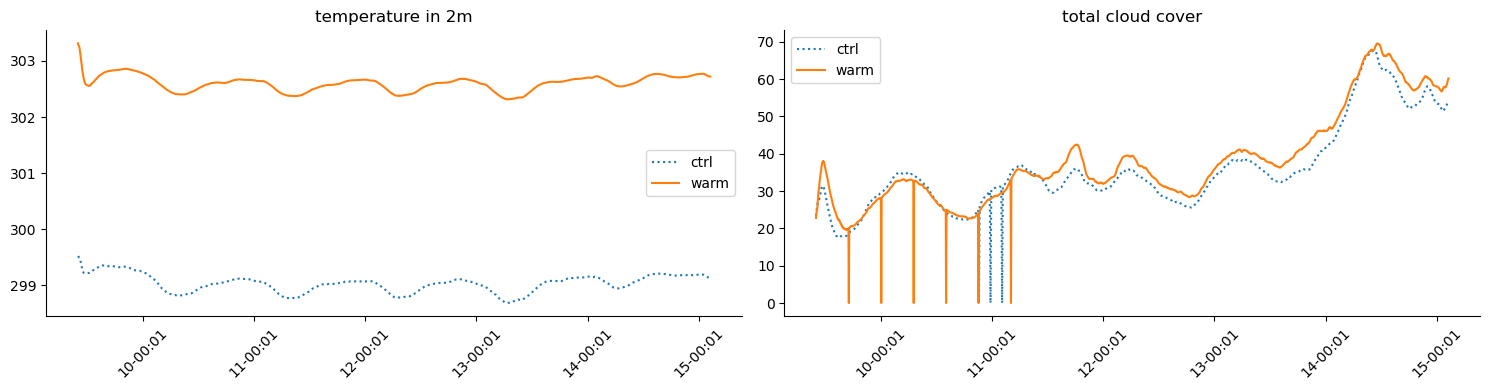

In [2]:
def fixedfig_some_domain_means_warmingrun(selected_variables, figsize=None, verbose=False):
    warming_timeseries = f'data/moistadabatic_{fh.timestamp()}.nc'
    control_timeseries = f'data/eurecasurface_{fh.timestamp()}.nc'
    if not os.path.exists(warming_timeseries):
        print(f'creating time series data: {warming_timeseries}')
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', warming_timeseries)
    if not os.path.exists(control_timeseries):
        print(f'creating time series data: {control_timeseries}')
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    if verbose: print(list(ctrl))
    # drop_vars = [v for v in list(ctrl) if not v in selected_variables]
    # ctrl = ctrl.drop_vars(drop_vars)
    # warm = warm.drop_vars(drop_vars)
    ctrl = ctrl[selected_variables]
    warm = warm[selected_variables]
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'ls' : ':'}]
    kwargs = [{'ls' : ':'}, {}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False, figsize=figsize)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

fig, axs = fixedfig_some_domain_means_warmingrun(['t_2m', 'clct'], figsize=(15,4))
fig.show()

['clct', 'lhfl_s', 'pres_sfc', 'qv_2m', 'rain_gsp_rate', 'rh_2m', 'shfl_s', 't_2m', 't_seasfc', 'tot_prec', 'tqc_dia', 'tqi_dia', 'tqv_dia', 'u_10m', 'v_10m', 'sob_t', 'sod_t', 'sou_t', 'thb_t']


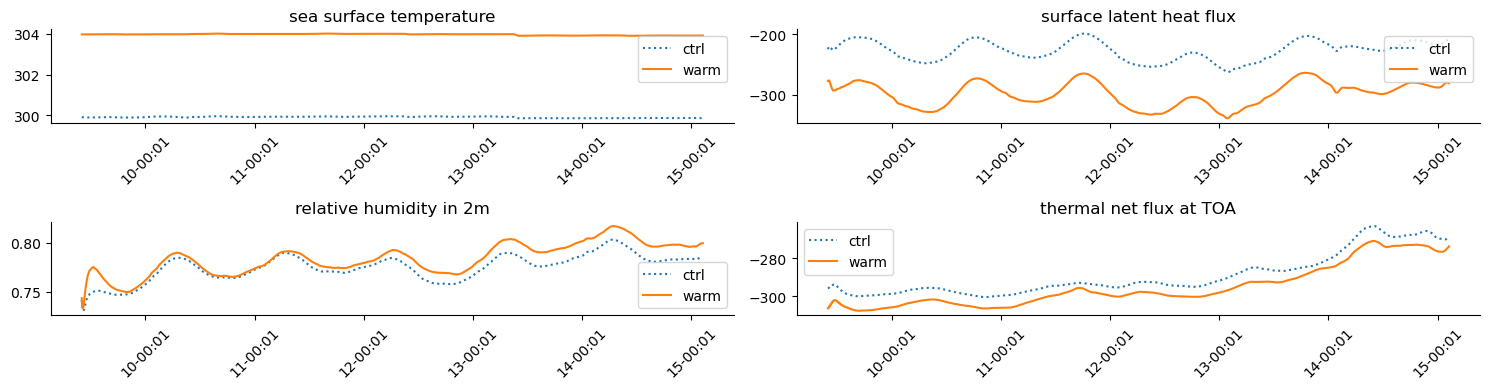

In [3]:
fig, axs = fixedfig_some_domain_means_warmingrun(['t_seasfc', 'lhfl_s', 'rh_2m', 'thb_t'], figsize=(15,4), verbose=True)
fig.savefig('img/fixedfig_some_domain_means_warmingrun_t_seasfc_lhfl_s_rh_2m_thb_t.png')
fig.show()

['clct', 'lhfl_s', 'pres_sfc', 'qv_2m', 'rain_gsp_rate', 'rh_2m', 'shfl_s', 't_2m', 't_seasfc', 'tot_prec', 'tqc_dia', 'tqi_dia', 'tqv_dia', 'u_10m', 'v_10m', 'sob_t', 'sod_t', 'sou_t', 'thb_t']


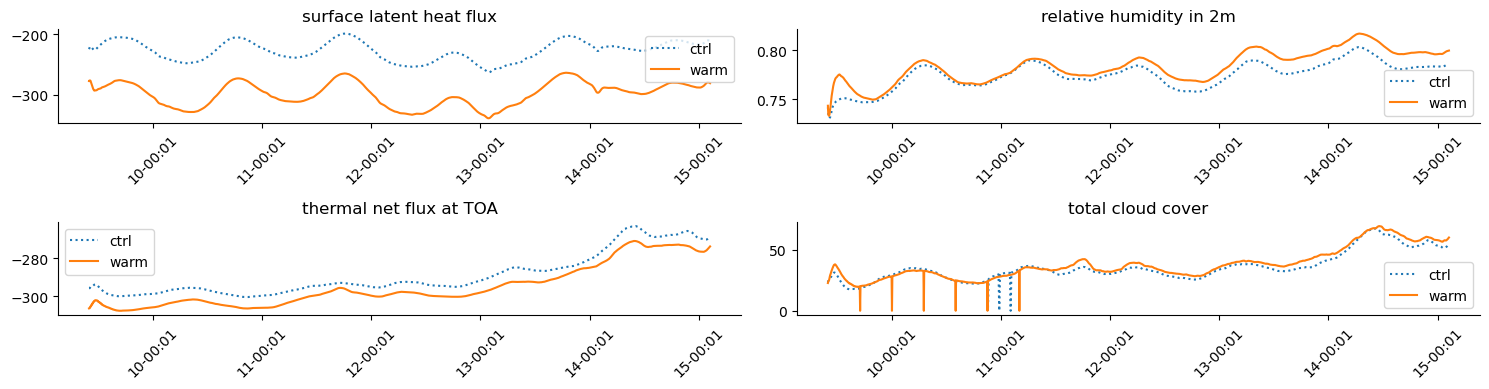

In [4]:
fig, axs = fixedfig_some_domain_means_warmingrun(['lhfl_s', 'rh_2m', 'thb_t', 'clct'], figsize=(15,4), verbose=True)
# fig.savefig('img/fixedfig_some_domain_means_warmingrun_t_seasfc_lhfl_s_rh_2m_thb_t.png')
fig.show()

In [10]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import postprocessing as pp
import matplotlib.pyplot as plt

def composit_dataset(path, cut_borders=True):
    datas = list()
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    datas.append(data)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    datas.append(data)
    
    return xr.merge(pp.time_overlap(datas))

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
data = composit_dataset(path)

In [11]:
d = data.sel(time=data.time.values[-1])
cloud = d.sel(cell=d['clct'] == 100)
clear = d.sel(cell=d['clct'] == 0)

In [12]:
def add_radiation_products(dataset, varnames):
    '''
    adds radiation related derived variables to the dataset
    
    these variables are:
    'albedo' as 'shortwave upward flux' / 'shortwave downward flux'
    'net radiation' as 'shortwave downward flux' + 'longwave upward flux'
    '''
    # Check if all required variable names are present in the varnames dictionary
    required_vars = ['shortwave downward flux', 'shortwave upward flux', 'longwave upward flux', 'albedo', 'net radiation']
    for varname in required_vars:
        if varname not in varnames:
            raise ValueError(f"'{varname}' is missing in the varnames dictionary.")

    # Calculate albedo and add it to the dataset
    dataset[varnames['albedo']] = dataset[varnames['shortwave upward flux']] / dataset[varnames['shortwave downward flux']]
    dataset[varnames['albedo']].attrs['standard_name'] = 'albedo'
    dataset[varnames['albedo']].attrs['long_name'] = 'albedo'
    dataset[varnames['albedo']].attrs['units'] = ''  # Albedo is a dimensionless quantity, so units are not specified.

    # Calculate net radiation and add it to the dataset
    dataset[varnames['net radiation']] = dataset[varnames['shortwave downward flux']] + dataset[varnames['longwave upward flux']]
    dataset[varnames['net radiation']].attrs['standard_name'] = 'net_radiation'
    dataset[varnames['net radiation']].attrs['long_name'] = 'net radiation'
    dataset[varnames['net radiation']].attrs['units'] = dataset[varnames['shortwave downward flux']].attrs['units']

    return dataset

varnames = {'shortwave downward flux': 'sod_t',
            'shortwave upward flux'  : 'sou_t',
            'longwave upward flux'   : 'thb_t',
            'albedo'                 : 'alb',
            'net radiation'          : 're'}

c = add_radiation_products(clear, varnames)['re']
c = c.max(dim='cell', keep_attrs=True)
c.values
# add_radiation_products(cloud, varnames)['re'].mean(dim='cell').values

array(-279.7691, dtype=float32)

In [13]:
cloud

<xarray.Dataset>
Dimensions:        (cell: 1253372)
Coordinates:
    lat            (cell) float64 9.501 9.5 9.507 9.515 ... 13.02 13.01 13.01
    lon            (cell) float64 -47.75 -47.76 -47.77 ... -51.36 -51.36 -51.37
  * cell           (cell) int64 396191 396193 396214 ... 4469909 4469910 4469911
    time           datetime64[ns] 2020-01-14T05:30:00
Data variables: (12/19)
    u_10m          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    v_10m          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    rh_2m          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    t_2m           (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    qv_2m          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    t_seasfc       (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    ...             ...
    clct           (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    pres_sfc       (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    sou_t          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    sob_t          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    sod_t          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
    thb_t          (cell) float32 dask.array<chunksize=(1253372,), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [14]:
clear

<xarray.Dataset>
Dimensions:        (cell: 901402)
Coordinates:
    lat            (cell) float64 9.744 9.756 9.763 9.758 ... 13.0 12.99 13.0
    lon            (cell) float64 -47.76 -47.76 -47.77 ... -51.38 -51.37 -51.37
  * cell           (cell) int64 398716 398718 398719 ... 4469904 4469905 4469906
    time           datetime64[ns] 2020-01-14T05:30:00
Data variables: (12/21)
    u_10m          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    v_10m          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    rh_2m          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    t_2m           (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    qv_2m          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    t_seasfc       (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    ...             ...
    sou_t          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    sob_t          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    sod_t          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    thb_t          (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    alb            (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
    re             (cell) float32 dask.array<chunksize=(901402,), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

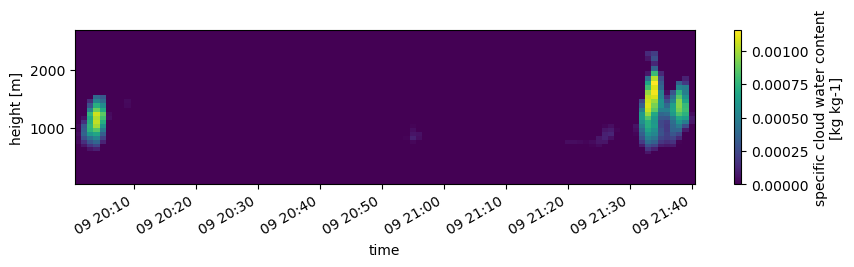

In [14]:
import eurec4a
ds = eurec4a.get_intake_catalog()['simulations']['ICON']['LES_CampaignDomain_control']['meteogram_BCO_DOM01'].to_dask()
ds['QC'].isel(time=slice(200, 300), height_2=slice(110, 150)).plot(x='time', figsize=(10,2))

In [1]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import xarray as xr    
import postprocessing as pp

import datetime# import now
t_start = datetime.datetime.now()
def t(): return datetime.datetime.now() - t_start
print('start', t()) #db


path  = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
files = fh.list_files(path, ['surface', 'DOM01'], full_path=True)
files = files[0:2]
files

print('before loop', t()) #db
for ifile in files:
    ofile = ifile.replace('surface', '0D')
    print(ifile)
    print('xr.merge', t()) #db
    data = xr.merge([pp.clean_surface_data(xr.open_dataset(ifile)),
                     pp.clean_surface_data(xr.open_dataset(ifile.replace('surface', 'radiation')), drop_dims=False) ])
    print('add_grid', t()) #db
    data = pp.add_grid(data)
    print('cut_borders', t()) #db
    data = pp.cut_borders(data)
    print('data.mean', t()) #db
    # data = data.mean(dim='cell', keep_attrs=True)
    print(list(data))
    print('saving to:')
    print(ofile)
    # data.to_netcdf(ofile)
    print()
data

start 0:00:00.000072
before loop 0:00:00.251095
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/./moist_adiabatic_05_DOM01_surface_20200109T100000Z.nc
xr.merge 0:00:00.251277
add_grid 0:00:00.462835
cut_borders 0:00:01.560153
data.mean 0:00:02.478611
['u_10m', 'v_10m', 'rh_2m', 't_2m', 'qv_2m', 't_seasfc', 'shfl_s', 'lhfl_s', 'tqv_dia', 'tqc_dia', 'tqi_dia', 'rain_gsp_rate', 'tot_prec', 'clct', 'pres_sfc', 'sou_t', 'sob_t', 'sod_t', 'thb_t']
saving to:
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/./moist_adiabatic_05_DOM01_0D_20200109T100000Z.nc

/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/./moist_adiabatic_05_DOM01_surface_20200109T103000Z.nc
xr.merge 0:00:02.478736
add_grid 0:00:02.732706
cut_borders 0:00:02.969011
data.mean 0:00:03.719517
['u_10m', 'v_10m', 'rh_2m', 't_2m', 'qv_2m', 't_seasfc', 'shfl_s', 'lhfl_s', 'tqv_dia', 'tqc_dia', 'tqi_dia', 'rain_gsp_rate', 'tot_prec', 'clct', 'pres_sfc', 'sou_t', '

<xarray.Dataset>
Dimensions:        (cell: 2154774, time: 6)
Coordinates:
    lat            (cell) float64 9.501 9.5 9.507 9.515 ... 13.02 13.01 13.01
    lon            (cell) float64 -47.75 -47.76 -47.77 ... -51.36 -51.36 -51.37
  * cell           (cell) int64 396191 396193 396214 ... 4469909 4469910 4469911
  * time           (time) datetime64[ns] 2020-01-09T10:30:00 ... 2020-01-09T1...
Data variables: (12/19)
    u_10m          (time, cell) float32 ...
    v_10m          (time, cell) float32 ...
    rh_2m          (time, cell) float32 ...
    t_2m           (time, cell) float32 ...
    qv_2m          (time, cell) float32 ...
    t_seasfc       (time, cell) float32 ...
    ...             ...
    clct           (time, cell) float32 ...
    pres_sfc       (time, cell) float32 ...
    sou_t          (time, cell) float32 ...
    sob_t          (time, cell) float32 ...
    sod_t          (time, cell) float32 ...
    thb_t          (time, cell) float32 ...
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [ ]:
data.mean(dim='time')

In [5]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import inspect

lines = inspect.getsource(fh.is_netcdf)
print(lines)

def is_netcdf(f):
    """
    Check if a file has the '.nc' extension, indicating it is a NetCDF file.

    Args:
        f (str): The file path to check for a '.nc' extension.

    Returns:
        bool: True if the file has the '.nc' extension, indicating it is a NetCDF file;
            False otherwise.

    Example:
        >>> file_path = "data.nc"
        >>> result = is_netcdf(file_path)
        >>> print(result)
        True

    Note:
        - This function is a simple check to determine if a file is a NetCDF file based on
          its extension. It does not validate the file's content.
    """
    return extension(f) == '.nc'



In [3]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh

directory = './'
searchstring = 'flush'

files = sorted(os.listdir(directory))
files = [f for f in files if f.endswith('.ipynb')]
files = files[-12::]

fh.scan_files(files, searchstring, verbose=True)

18_whats_with_the_boundaries.ipynb
Found string in 18_whats_with_the_boundaries.ipynb::375
	     "    print(d[varnames['temperature']].values, flush=True) #db\n",
Found string in 18_whats_with_the_boundaries.ipynb::377
	     "    print(d[varnames['temperature']].values, flush=True) #db\n",
Found string in 18_whats_with_the_boundaries.ipynb::388
	     "print('latbc_script', flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::389
	     "print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::390
	     "print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::391
	     "print('division: ', division, flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::392
	     "for f in latbc_files: print(f, flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::393
	     "print('', flush=True)\n",
Found string in 18_whats_with_the_boundaries.ipynb::408
	     " 

[{'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 375,
  'line': '    "    print(d[varnames[\'temperature\']].values, flush=True) #db\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 377,
  'line': '    "    print(d[varnames[\'temperature\']].values, flush=True) #db\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 388,
  'line': '    "print(\'latbc_script\', flush=True)\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 389,
  'line': '    "print(\'IN_DIRECTORY: \', IN_DIRECTORY, flush=True)\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 390,
  'line': '    "print(\'OUT_DIRECTORY: \', OUT_DIRECTORY, flush=True)\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 391,
  'line': '    "print(\'division: \', division, flush=True)\\n",'},
 {'filepath': '18_whats_with_the_boundaries.ipynb',
  'line_number': 392,
  'line': '    "for f in l